# Active Learning: Q1 (b): i

In [0]:
''' Q1(b) i:
use uncertainty sampling (Least confident, Margin Sampling, & Entropy) to label points.
Compare the three measures of informativeness.
'''

' Q1(b) i:\nuse uncertainty sampling (Least confident, Margin Sampling, & Entropy) to label points.\nCompare the three measures of informativeness.\n'



---


In the following segment, we develop the three UNCERTAINITY SAMPLING approaches: 

*   Least Confidence Sampling
*   Margin Sampling
*   Entropy Sampling


---




After this, we have shown a comparison among the above three technques on the basis of the following metrics tested on test data:

*   Accuracy
*   Precision Score
*   F1 Score


---




Please note that we shall be using **SVM classifier** for our classification purposes!


---








In [0]:
# Importing required libraries

import numpy as np 
import pandas as pd 
import math
from statistics import mean 
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split 
from sklearn import datasets
from scipy.stats import entropy
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# split dataset into test set, train set and unlabel pool 

def split(dataset, train_size, test_size): 
	x = dataset[:, :-1] 
	y = dataset[:, -1] 
	x_train, x_pool, y_train, y_pool = train_test_split( 
		x, y, train_size = train_size) 
	unlabel, x_test, label, y_test = train_test_split( 
		x_pool, y_pool, test_size = test_size) 
	return x_train, y_train, x_test, y_test, unlabel, label

In [0]:
# function defining all types of uncertainity sampling techniques (least confidence, margin, entropy)

def uncertainity_sampling(name, unlabel, classifier, percent_of_samples, dataset):

    # For LEAST CONFIDENCE SAMPLING
    if name == 'least_confidence':
        proba = classifier.predict_proba(unlabel)
        prob_max = proba.max(axis=1)
        sorted_idx = np.argsort(prob_max)
        #print('Probability distribution of Top 5 Selection through LEAST CONFIDENCE: \n')
        #for i in range(1,6):
            #print("Selection #" + str(i) + ': ' + str(proba[sorted_idx[i-1]]) + '\n')
        
        uncrt_pt_ind = [] 
        for i in range(math.floor(percent_of_samples * 0.01 * dataset.shape[0])):
             uncrt_pt_ind.append(sorted_idx[i])
        return uncrt_pt_ind

    # For MARGIN SAMPLING
    if name == 'margin_sampling':
        proba = classifier.predict_proba(unlabel)
        part = np.partition(-proba, 1, axis=1)
        margin = - part[:, 0] + part[:, 1]
        sorted_idx = np.argsort(margin)
        # print('Probability distribution of Top 5 Selection through MARGIN SAMPLING: \n')
        # for i in range(1,6):
        #     print("Selection #" + str(i) + ': ' + str(proba[sorted_idx[i-1]]) + '\n')
        uncrt_pt_ind = [] 
        for i in range(math.floor(percent_of_samples * 0.01 * dataset.shape[0])):
             uncrt_pt_ind.append(sorted_idx[i])
        return uncrt_pt_ind

    # For ENTROPY SAMPLING
    if name == 'entropy':
        proba = classifier.predict_proba(unlabel)
        
        entr = entropy(proba.T)
        sorted_idx = np.argsort(entr)
        # print('Probability distribution of Top 5 Selection through ENTROPY: \n')
        # for i in range(1,6):
        #     print("Selection #" + str(i) + ': ' + str(proba[sorted_idx[len(entr) - i]]) + '\n')
        uncrt_pt_ind = [] 
        for i in range(math.floor(percent_of_samples * 0.01 * dataset.shape[0])):
             uncrt_pt_ind.append(sorted_idx[-i -1])
        return uncrt_pt_ind

In [0]:
# Loading dataset
X_digits, y_digits = datasets.load_digits(return_X_y=True)
stack = np.vstack((X_digits.T, y_digits.T))
dataset = stack.T

# feature scalling 
sc = StandardScaler() 
dataset[:, :-1] = sc.fit_transform(dataset[:, :-1]) 


1. LEAST CONFIDENCE SAMPLING

In [0]:
#############################################################################################
sampling_name = 'least_confidence'
percent_of_samples = 10
train_size = 0.10
test_size = 0.20

############################################################################################

############################################################################################
# run the model 10 times and take the average of its accuracies, precision_score & f1_score 
accuracy1 = []
prec_score1 = []
f1_score1 = []

for i in range(10): 

    # split dataset into train(10 %), test(20 %), unlabel(70 %) 
    x_train, y_train, x_test, y_test, unlabel, label = split(dataset, train_size, test_size) 

    # train model by active learning by labelling the extra 10% datapoints
    for i in range(1): 
        classifier1 = SVC(decision_function_shape='ovo', probability = True)
        classifier1.fit(x_train, y_train) 
        y_probab = classifier1.predict_proba(unlabel)[:, 0] 

        # Obtaining the required unlabelled data points for labelling by Oracle
        uncrt_pt_ind = uncertainity_sampling(sampling_name, unlabel, classifier1, percent_of_samples, dataset)
        
        # Appending the newly labelled data points into the training set
        x_train = np.append(unlabel[uncrt_pt_ind, :], x_train, axis = 0)
        proba_chosen_samples =  classifier1.predict_proba(unlabel[uncrt_pt_ind, :])
        y_train = np.append(label[uncrt_pt_ind], y_train)

        # Deleting the newly labelled data points from the unlabelled pool
        unlabel = np.delete(unlabel, uncrt_pt_ind, axis = 0) 
        label = np.delete(label, uncrt_pt_ind) 

    # Running final classification model for the new training data set
    classifier2 = SVC(decision_function_shape='ovo', probability = True)
    classifier2.fit(x_train, y_train) 

    # Obtaining the performance of the final ACTIVE LEARNING MODEL
    accuracy1.append(classifier2.score(x_test, y_test)) 
    prec_score1.append(metrics.precision_score(classifier2.predict(x_test), y_test, average = 'macro')) 
    f1_score1.append(metrics.f1_score(classifier2.predict(x_test), y_test, average = 'macro')) 

############################################################################################


############################################################################################
# Printing the performace of the ACTIVE LEARNING MODEL
print("Accuracy by ACTIVE MODEL [with Least Confidence Sampling] :", mean(accuracy1)*100) 
print("Precision Score by ACTIVE MODEL [with Least Confidence Sampling] :", mean(prec_score1))
print("F1 Score by ACTIVE MODEL [with Least Confidence Sampling] :", mean(f1_score1)) 

############################################################################################

Accuracy by ACTIVE MODEL [with Least Confidence Sampling] : 96.75925925925925
Precision Score by ACTIVE MODEL [with Least Confidence Sampling] : 0.9674401578445708
F1 Score by ACTIVE MODEL [with Least Confidence Sampling] : 0.9669540856185114


In [0]:
print('The probablity distributions of top 5 samples chosen by LEAST CONFIDENCE SAMPLING are: \n')
print('Selection# 1: ' + str(proba_chosen_samples[0]) + '\n')
print('Selection# 2: ' + str(proba_chosen_samples[1]) + '\n')
print('Selection# 3: ' + str(proba_chosen_samples[2]) + '\n')
print('Selection# 4: ' + str(proba_chosen_samples[3]) + '\n')
print('Selection# 5: ' + str(proba_chosen_samples[4]) + '\n')

The probablity distributions of top 5 samples chosen by LEAST CONFIDENCE SAMPLING are: 

Selection# 1: [0.04657279 0.12954407 0.10241088 0.16382341 0.06818773 0.0417824
 0.08687414 0.13251074 0.17854801 0.04974581]

Selection# 2: [0.04941764 0.13121811 0.07496966 0.06466836 0.17980464 0.10887817
 0.09733066 0.17944162 0.03765182 0.07661933]

Selection# 3: [0.03919045 0.12537048 0.0828352  0.13709944 0.06579437 0.15359503
 0.08044748 0.05170077 0.18335471 0.08061208]

Selection# 4: [0.02355197 0.10525635 0.18429886 0.10430115 0.04303902 0.09025985
 0.07582016 0.11988929 0.10981934 0.143764  ]

Selection# 5: [0.03457714 0.13273668 0.18516457 0.08131302 0.07999559 0.10358457
 0.08527262 0.17109725 0.03978387 0.08647469]



2. MARGIN SAMPLING

In [0]:
#############################################################################################
sampling_name = 'margin_sampling'
percent_of_samples = 10
train_size = 0.10
test_size = 0.20

############################################################################################

############################################################################################
# run the model 10 times and take the average of its accuracies, precision_score & f1_score 
accuracy2 = []
prec_score2 = []
f1_score2 = []

for i in range(10): 

    # split dataset into train(10 %), test(20 %), unlabel(70 %) 
    x_train, y_train, x_test, y_test, unlabel, label = split(dataset, train_size, test_size) 

    # train model by active learning by labelling the extra 10% data points
    for i in range(1): 
        classifier1 = SVC(decision_function_shape='ovo', probability = True)
        classifier1.fit(x_train, y_train) 
        y_probab = classifier1.predict_proba(unlabel)[:, 0] 

        # Obtaining the required unlabelled data points for labelling by Oracle
        uncrt_pt_ind = uncertainity_sampling(sampling_name, unlabel, classifier1, percent_of_samples, dataset)
        
        # Appending the newly labelled data points into the training set
        x_train = np.append(unlabel[uncrt_pt_ind, :], x_train, axis = 0) 
        proba_chosen_samples =  classifier1.predict_proba(unlabel[uncrt_pt_ind, :])
        y_train = np.append(label[uncrt_pt_ind], y_train)

        # Deleting the newly labelled data points from the unlabelled pool
        unlabel = np.delete(unlabel, uncrt_pt_ind, axis = 0) 
        label = np.delete(label, uncrt_pt_ind) 

    # Running final classification model for the new training data set
    classifier2 = SVC(decision_function_shape='ovo', probability = True)
    classifier2.fit(x_train, y_train) 

    # Obtaining the performance of the final ACTIVE LEARNING MODEL
    accuracy2.append(classifier2.score(x_test, y_test)) 
    prec_score2.append(metrics.precision_score(classifier2.predict(x_test), y_test, average = 'macro')) 
    f1_score2.append(metrics.f1_score(classifier2.predict(x_test), y_test, average = 'macro')) 

############################################################################################

############################################################################################
# Printing the performace of the ACTIVE LEARNING MODEL
print("Accuracy by ACTIVE MODEL [with Margin Sampling] :", mean(accuracy2)*100) 
print("Precision Score by ACTIVE MODEL [with Margin Sampling] :", mean(prec_score2))
print("F1 Score by ACTIVE MODEL [with Margin Sampling] :", mean(f1_score2)) 

############################################################################################


Accuracy by ACTIVE MODEL [with Margin Sampling] : 96.38888888888889
Precision Score by ACTIVE MODEL [with Margin Sampling] : 0.9645366348169592
F1 Score by ACTIVE MODEL [with Margin Sampling] : 0.9631624064741922


In [0]:
print('The probablity distributions of top 5 samples chosen by MARGIN SAMPLING are: \n')
print('Selection# 1: ' + str(proba_chosen_samples[0]) + '\n')
print('Selection# 2: ' + str(proba_chosen_samples[1]) + '\n')
print('Selection# 3: ' + str(proba_chosen_samples[2]) + '\n')
print('Selection# 4: ' + str(proba_chosen_samples[3]) + '\n')
print('Selection# 5: ' + str(proba_chosen_samples[4]) + '\n')

The probablity distributions of top 5 samples chosen by MARGIN SAMPLING are: 

Selection# 1: [0.0123915  0.19682137 0.04673639 0.04359342 0.22252091 0.02701827
 0.02768241 0.2205873  0.11061489 0.09203354]

Selection# 2: [0.19308418 0.04183741 0.03515971 0.03639527 0.19040878 0.12904317
 0.18468107 0.02788946 0.07452239 0.08697856]

Selection# 3: [0.02490261 0.10074397 0.02621519 0.12037626 0.05030705 0.2418414
 0.09592413 0.02169381 0.0732691  0.24472648]

Selection# 4: [0.01561304 0.11415513 0.20902415 0.0767634  0.145906   0.05831192
 0.0473433  0.03428365 0.2123208  0.0862786 ]

Selection# 5: [0.01205506 0.12719316 0.10502598 0.12253351 0.06474328 0.17152216
 0.02843391 0.09589807 0.16795269 0.10464219]



3. ENTROPY SAMPLING

In [0]:
#############################################################################################
sampling_name = 'entropy'
percent_of_samples = 10
train_size = 0.10
test_size = 0.20

############################################################################################

############################################################################################
# run the model 10 times and take the average of its accuracies, precision_score & f1_score 
accuracy3 = []
prec_score3 = []
f1_score3 = []

for i in range(10): 

    # split dataset into train(10 %), test(20 %), unlabel(70 %) 
    x_train, y_train, x_test, y_test, unlabel, label = split(dataset, train_size, test_size) 

    # train model by active learning by labelling the extra 10% data points
    for i in range(1): 
        classifier1 = SVC(decision_function_shape='ovo', probability = True)
        classifier1.fit(x_train, y_train) 
        y_probab = classifier1.predict_proba(unlabel)[:, 0] 

        # Obtaining the required unlabelled data points for labelling by Oracle
        uncrt_pt_ind = uncertainity_sampling(sampling_name, unlabel, classifier1, percent_of_samples, dataset)
        
        # Appending the newly labelled data points into the training set
        x_train = np.append(unlabel[uncrt_pt_ind, :], x_train, axis = 0) 
        proba_chosen_samples =  classifier1.predict_proba(unlabel[uncrt_pt_ind, :])
        y_train = np.append(label[uncrt_pt_ind], y_train)

        # Deleting the newly labelled data points from the unlabelled pool
        unlabel = np.delete(unlabel, uncrt_pt_ind, axis = 0) 
        label = np.delete(label, uncrt_pt_ind) 

    # Running final classification model for the new training data set
    classifier2 = SVC(decision_function_shape='ovo', probability = True)
    classifier2.fit(x_train, y_train) 

    # Obtaining the performance of the final ACTIVE LEARNING MODEL
    accuracy3.append(classifier2.score(x_test, y_test)) 
    prec_score3.append(metrics.precision_score(classifier2.predict(x_test), y_test, average = 'macro')) 
    f1_score3.append(metrics.f1_score(classifier2.predict(x_test), y_test, average = 'macro')) 

############################################################################################

############################################################################################
# Printing the performace of the ACTIVE LEARNING MODEL
print("Accuracy by ACTIVE MODEL [with Entropy Sampling] :", mean(accuracy3)*100) 
print("Precision Score by ACTIVE MODEL [with Entropy Sampling] :", mean(prec_score3))
print("F1 Score by ACTIVE MODEL [with Entropy Sampling] :", mean(f1_score3)) 

############################################################################################


Accuracy by ACTIVE MODEL [with Entropy Sampling] : 95.49382716049382
Precision Score by ACTIVE MODEL [with Entropy Sampling] : 0.9543670046970342
F1 Score by ACTIVE MODEL [with Entropy Sampling] : 0.9540263515553131


In [0]:
print('The probablity distributions of top 5 samples chosen by ENTROPY SAMPLING are: \n')
print('Selection# 1: ' + str(proba_chosen_samples[0]) + '\n')
print('Selection# 2: ' + str(proba_chosen_samples[1]) + '\n')
print('Selection# 3: ' + str(proba_chosen_samples[2]) + '\n')
print('Selection# 4: ' + str(proba_chosen_samples[3]) + '\n')
print('Selection# 5: ' + str(proba_chosen_samples[4]) + '\n')

The probablity distributions of top 5 samples chosen by ENTROPY SAMPLING are: 

Selection# 1: [0.19378701 0.02249303 0.0706992  0.08990276 0.08830552 0.24091064
 0.046119   0.08132896 0.08196506 0.08448883]

Selection# 2: [0.07333991 0.03640632 0.2290786  0.14694106 0.07566713 0.1020098
 0.17563599 0.02629856 0.03476647 0.09985615]

Selection# 3: [0.00941865 0.10245706 0.17255025 0.07221264 0.04073349 0.0673303
 0.05383465 0.10658805 0.2057047  0.1691702 ]

Selection# 4: [0.19100793 0.0459144  0.0818484  0.09673782 0.05742592 0.07525192
 0.23747606 0.0190953  0.0564847  0.13875754]

Selection# 5: [0.24773105 0.03545367 0.0386211  0.12264771 0.04517162 0.10928911
 0.07648324 0.03043276 0.16666921 0.12750054]



COMPARISION OF THE UNCERTAINITY SAMPLING APPROACHES

In [0]:
compare = pd.DataFrame({
    'Method': ['Least_Confidence', 'Margin', 'Entropy'],
    'Accuracy': [float("%0.4f" % (mean(accuracy1))), float("%0.4f" % (mean(accuracy2))), float("%0.4f" % (mean(accuracy3)))],
    'F1_Score': [float("%0.4f" % (mean(f1_score1))), float("%0.4f" % (mean(f1_score2))), float("%0.4f" % (mean(f1_score3)))],
    'Precision_Score': [float("%0.4f" % (mean(prec_score1))), float("%0.4f" % (mean(prec_score2))), float("%0.4f" % (mean(prec_score3)))]
})

In [0]:
print('Comparison of the three Uncertainity Sampling Approaches after sampling additional 10% of data points: \n')
print(compare)

Comparison of the three Uncertainity Sampling Approaches after sampling additional 10% of data points: 

             Method  Accuracy  F1_Score  Precision_Score
0  Least_Confidence    0.9676    0.9670           0.9674
1            Margin    0.9639    0.9632           0.9645
2           Entropy    0.9549    0.9540           0.9544


Comparison of the two UNCERTAINITY Sampling Techniques after each iteration of 10% Sampling: 

       Sampling_Name  Percent_Labelled_Samples  Accuracy
0   least_confidence                        10  0.935185
1   least_confidence                        20  0.969136
2   least_confidence                        30  0.984568
3   least_confidence                        40  0.987654
4   least_confidence                        50  0.984568
5    margin_sampling                        10  0.935185
6    margin_sampling                        20  0.978395
7    margin_sampling                        30  0.984568
8    margin_sampling                        40  0.987654
9    margin_sampling                        50  0.984568
10           entropy                        10  0.935185
11           entropy                        20  0.959877
12           entropy                        30  0.984568
13           entropy                        40  0.984568
14           entropy                        50  0.

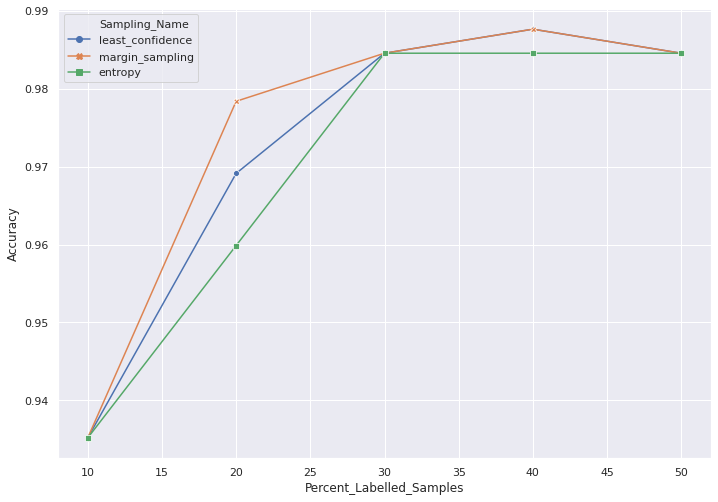

In [0]:
# COMPARISON VISUALIZATION

acc = []
name = []
labelled_samples_percent = []
percent_of_samples = 10
train_size = 0.10
test_size = 0.20

X_train, Y_train, X_test, Y_test, Unlabel, Label = split(dataset, train_size, test_size)

for sampling_name in ['least_confidence', 'margin_sampling', 'entropy']:

    for i in range(1): 

        # Assigning x_train, x_test, y_train, y_test, unabel & label 
        x_train, y_train, x_test, y_test, unlabel, label =  X_train, Y_train, X_test, Y_test, Unlabel, Label

        # train model by active learning by labelling the extra 10% data points with each loop (4 loops = 40% data)
        for i in range(4): 
            classifier1 = SVC(decision_function_shape='ovo', probability = True)
            classifier1.fit(x_train, y_train) 
            
            ###############################################################################
            acc.append(classifier1.score(x_test, y_test)) 
            labelled_samples_percent.append((i+1)*10)
            name.append(sampling_name)
            ###############################################################################

            y_probab = classifier1.predict_proba(unlabel)[:, 0] 

            # Obtaining the required unlabelled data points for labelling by Oracle
            uncrt_pt_ind = uncertainity_sampling(sampling_name, unlabel, classifier1, percent_of_samples, dataset)
            
            # Appending the newly labelled data points into the training set
            x_train = np.append(unlabel[uncrt_pt_ind, :], x_train, axis = 0) 
            y_train = np.append(label[uncrt_pt_ind], y_train)

            # Deleting the newly labelled data points from the unlabelled pool
            unlabel = np.delete(unlabel, uncrt_pt_ind, axis = 0) 
            label = np.delete(label, uncrt_pt_ind) 

            # Running final classification model for the new training data set
            classifier2 = SVC(decision_function_shape='ovo', probability = True)
            classifier2.fit(x_train, y_train) 

        ###############################################################################
        acc.append(classifier2.score(x_test, y_test)) 
        labelled_samples_percent.append((i+2)*10)
        name.append(sampling_name)
        ###############################################################################

            
# Creating a DataFrame for data visualization:
data_viz = pd.DataFrame({
    'Sampling_Name': name,
    'Percent_Labelled_Samples': labelled_samples_percent,
    'Accuracy': acc
})

print('Comparison of the two UNCERTAINITY Sampling Techniques after each iteration of 10% Sampling: \n')
print(data_viz)
print()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.lineplot(x="Percent_Labelled_Samples", y="Accuracy",
                  hue="Sampling_Name", style="Sampling_Name",
                  markers=True, dashes=False, data=data_viz)

In [0]:
print('Comparison of the two Uncertainity Sampling Techniques after each iteration of 10% Sampling: \n')

data_viz

Comparison of the two Uncertainity Sampling Techniques after each iteration of 10% Sampling: 



,Sampling_Name,Percent_Labelled_Samples,Accuracy
0,least_confidence,10,0.895062
1,least_confidence,20,0.959877
2,least_confidence,30,0.969136
3,least_confidence,40,0.969136
4,least_confidence,50,0.969136
5,margin_sampling,10,0.895062
6,margin_sampling,20,0.962963
7,margin_sampling,30,0.966049
8,margin_sampling,40,0.969136
9,margin_sampling,50,0.972222


END OF Q1(b)i